<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Keras_WithDeeplizard/blob/master/19_Fine_Tuning_MobileNet_On_Custom_Data_Set_With_TensorFlow's_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning MobileNet On A Custom Data Set With TensorFlow's Keras API
在这一集，我们将建立在我们所学到的关于MobileNet与我们用于微调的技术相结合的自定义图像数据集微调MobileNet。

当我们先前在较早的情节中演示微调的想法时，我们使用的是猫和狗数据集。 但是，我们注意到，最初由MobileNet和VGG16进行训练的ImageNet数据集已经包含了许多不同类型的猫狗品种。

由于该模型在其原始训练过程中已经学习了猫和狗的特征，因此我们无需为模型进行太多调整即可轻松地对这些图像进行分类。

## 1.构建模型
我们将下载MobileNet模型，并打印它的摘要。


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

接下来，我们提出模型的第一层到倒数第六层，并将其存储在这个变量x中。

In [ ]:
x = mobile.layers[-6].output

我们将使用它来构建一个新模型。这个新模型将包括原来的MobileNet第一层到最后第六层。我们不包括最初的MobileNet的最后五层。通过查看原始模型的总结，我们可以看到，由于不包括最后五层，我们将包括最后一个global_average_pooling之前的所有内容。

**注意**当你微调一个模型时，我们选择切断的图层数量会因不同的场景而不同，但我通过实验发现，仅删除最后5个图层对于这个特定的任务是很好的。因此，在这种设置下，我们将保留绝大多数原来的MobileNet架构，总共有88层。

现在，我们创建一个输出层，我们将调用输出，这将是一个密集的层，有10个输出节点，用于10个对应的类，我们将使用softmax激活函数。

In [ ]:
output = Dense(units=10,activation='softmax')(x)

现在，我们构建新的微调模型，我们将其称为model。

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
model = Model(inputs = mobile.input,outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

**注意:**您可以通过用于创建模型的Model构造器看到，这是一个使用Keras Functional API创建的模型，而不是我们在以前的章节中使用的Sequential API。这就是为什么我们用来创建模型的格式可能与你习惯的格式有点不同。

为了构建新的模型，我们创建了model类的一个实例，并将模型的输入指定为等于原始MobileNet的输入，然后我们将模型的输出定义为等于我们在上面直接创建的输出变量。

这创建了一个新的模型，它与原来的MobileNet完全相同，直到原来的模型的倒数第六层到最后一层。我们没有包括最后5个原始的MobileNet层，但是我们有一个新的层，即我们用10个输出节点创建的输出层。

现在，当我们在新数据集上进行训练时，我们需要选择我们真正想要训练的层数。

我们仍然想保留很多原来的MobileNet已经从ImageNet中学到的东西，通过冻结许多层的权值，特别是早期的，但是我们确实需要训练一些层，因为模型仍然需要学习关于这个新数据集的特征。

我做了一些实验，发现训练最后23层将给我们一个相当不错的执行模型。


In [ ]:
lay = model.layers
print(type(lay))
print(lay)
print(len(lay))

<class 'list'>
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe034d8d160>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdff2eb5cf8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdff265d710>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fdff2624860>, <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fdfe0370eb8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdfe037c9e8>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fdfe03859b0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdfe037c2e8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fdfe038fb70>, <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fdfe0385a20>, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fdfe039ce80>, <tensorflow.python.keras.l

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

**注意**只训练最后23层不一定是需要训练的最佳层数。你可以自己尝试一下，如果你可以通过训练更多或更少的层次来获得更好的结果，请在评论中告诉我。

因此，当我们在新的数据集上拟合模型时，将训练到最后的第23层和之后的所有层。上面的所有层都不会被训练，所以它们原来的ImageNet权重将保持不变。

现在看看模型总结，我们可以看到新的模型架构，以及可培训参数的数量是如何从原始模型更改的。

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## 2. 训练模型
现在，我们编译这个模型的方法和我们在本课程中编译其他模型的方法一样

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

类似地，我们调用fit()来训练模型，就像我们对其他模型所做的那样

In [ ]:
# 在colab上使用的云端数据
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/Sign-Language-Digits-Dataset"

# 更改当前系统的路径
os.chdir(path)
# 显示当前路径的文件夹名字
print(os.listdir())

# 获得当前路径
os.getcwd()

['valid', 'test', 'train']


'/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/Sign-Language-Digits-Dataset'

In [ ]:
os.chdir("..")
print(os.listdir())

['dogs-vs-cats', 'MobileNet-samples', 'Sign-Language-Digits-Dataset']


In [ ]:

train_path = './Sign-Language-Digits-Dataset/train'
valid_path = './Sign-Language-Digits-Dataset/valid'
test_path = './Sign-Language-Digits-Dataset/test'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1710 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
171/171 - 549s - loss: 0.6170 - accuracy: 0.8181 - val_loss: 0.2329 - val_accuracy: 0.9633
Epoch 2/30
171/171 - 6s - loss: 0.1094 - accuracy: 0.9801 - val_loss: 0.1085 - val_accuracy: 0.9867
Epoch 3/30
171/171 - 6s - loss: 0.0543 - accuracy: 0.9936 - val_loss: 0.0798 - val_accuracy: 0.9867
Epoch 4/30
171/171 - 6s - loss: 0.0350 - accuracy: 0.9947 - val_loss: 0.0784 - val_accuracy: 0.9867
Epoch 5/30
171/171 - 6s - loss: 0.0224 - accuracy: 0.9977 - val_loss: 0.0748 - val_accuracy: 0.9867
Epoch 6/30
171/171 - 6s - loss: 0.0181 - accuracy: 0.9982 - val_loss: 0.0669 - val_accuracy: 0.9900
Epoch 7/30
171/171 - 6s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0729 - val_accuracy: 0.9867
Epoch 8/30
171/171 - 6s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0728 - val_accuracy: 0.9867
Epoch 9/30
171/171 - 6s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9900
Epoch 10/30
171/171 - 6s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.99

在训练的早期，训练集的准确率已经达到100%。我们的验证精度落后了一些，只有90%，所以我们在这里进行了一点过度拟合，但我们可以看到，它没有在我们到达最后一个纪元时停止。

也许运行更多的时代将产生更好的结果。自己试试!此外，你可以随意调整任何超参数，训练更多或更少的层，并进行试验，看看是否可以得到更好的结果。在评论中分享你的经验吧!

## 3.绘制混乱矩阵描述预测结果

通过从未打乱的测试集中抓取类，我们以与前面章节中看到的相同的方式设置test_labels。

In [ ]:
test_labels = test_batches.classes
print(test_labels)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


我们使用model.predict()来运行预测，就像我们在前面的章节中使用这个函数一样。

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

然后我们使用scikit-learn在上一集导入的混淆矩阵创建一个混淆矩阵对象。

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# 准备数据
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

现在我们只打印test_batch中的class_indices，这样我们就可以看到类的顺序，并在为混淆矩阵创建标签时以相同的顺序指定它们。

In [ ]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

在创建标签之后，我们绘制我们的混淆矩阵。

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 1]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


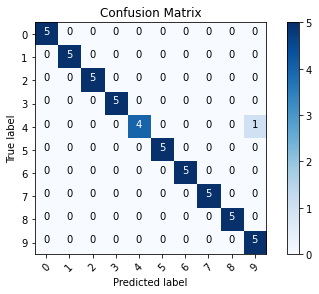

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

看起来很好!看看蓝色的对角线，它包含了所有正确预测的样本，我们可以知道这个模型做得很好。每个类都有5个样本，这里有很多5个样本。总的来说，模型给出了50个错误预测中的5个，这使我们在测试集上的准确率达到了99%。还不错。正如前面提到的，这个模型仍然有改进的余地，所以如果您实现了任何一个，并且在测试集上获得了超过99%的准确率，请在评论中分享